# B1 BayesianModel

---
## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import pyro

In [3]:
# Google Colab用の設定．
if False:
    from google.colab import drive
    drive.mount('/content/gdrive')
    sys.path.append('/content/gdrive/My Drive/Colab Notebooks/RLPack')

---
## 1. Modeling

In [4]:
def model(EV_data, face, mortality, n_counts=1000):
    face = torch.tensor(face)
    mortality = torch.tensor(mortality)
    
    ds = pyro.sample('ds', pyro.distributions.Normal(n_counts*mortality, np.sqrt(n_counts*mortality*(1-mortality))))
    Bs = face * ds  # 0フロアしないこと．MCMCが効かなくなる．
    EV = pyro.sample('EV', pyro.distributions.Normal(torch.sum(-Bs), 0.001), 
                     obs=EV_data)
    return EV

In [5]:
def average_EV(face, mortality, n_counts=1000):
    return -np.sum(n_counts * mortality * face)
    

In [6]:
from pyro.infer.mcmc import MCMC, NUTS

def calc_posterior(EV_data, face, mortality, num_samples, warmup_steps):
    EV_data = torch.tensor(EV_data)

    nuts_kernel = NUTS(model, adapt_step_size=True)
    mcmc_run = MCMC(
        nuts_kernel,
        num_samples=num_samples,
        warmup_steps=warmup_steps,
    )

    mcmc_run.run(EV_data, face, mortality)
    
    return mcmc_run

---
## 2. Samples

In [7]:
num_samples = 10000
warmup_steps=500

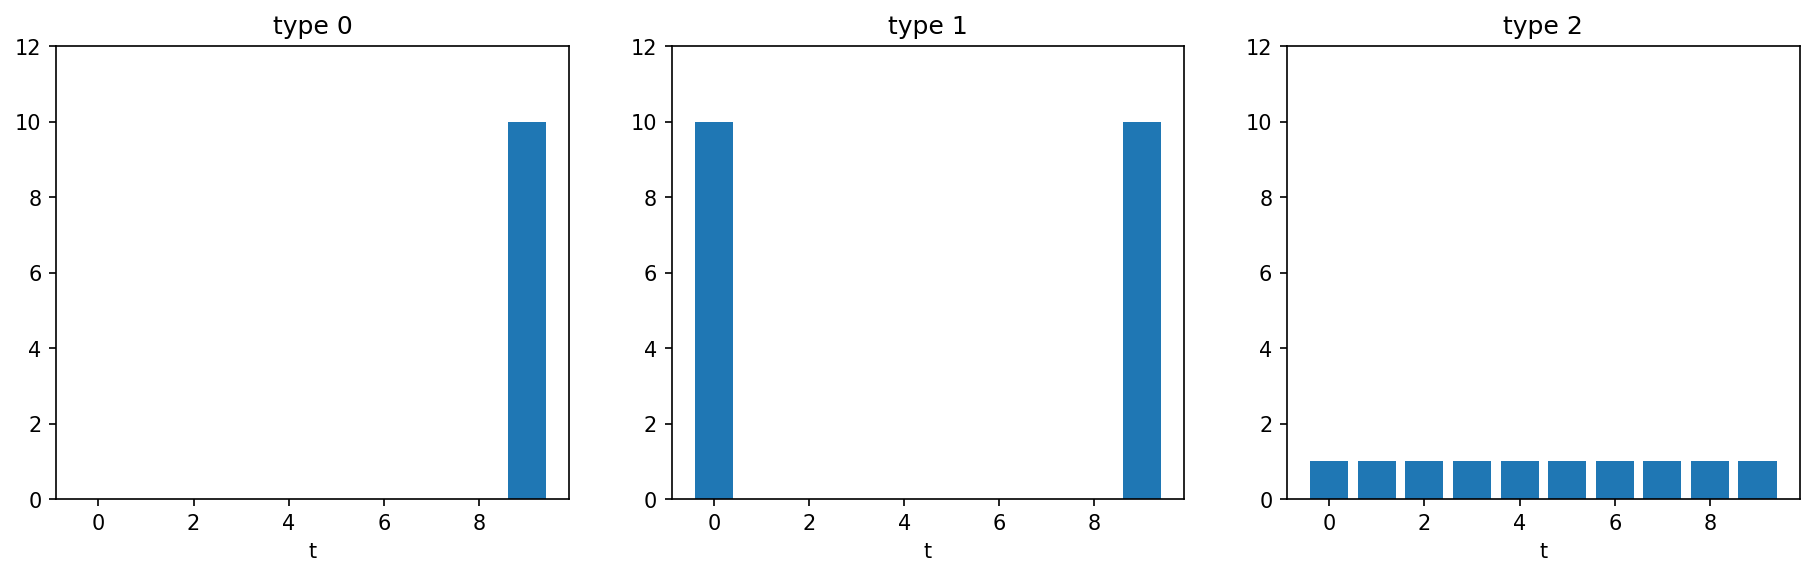

In [8]:
# benefit list
fig = plt.figure(figsize=(15, 4), dpi=150)

ax0 = fig.add_subplot(1, 3, 1)
ax0.bar(np.arange(10), np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 10]))
ax0.set_title('type 0')
ax0.set_ylim(0, 12)
ax0.set_xlabel('t')

ax1 = fig.add_subplot(1, 3, 2)
ax1.bar(np.arange(10),np.array([10, 0, 0, 0, 0, 0, 0, 0, 0, 10]))
ax1.set_title('type 1')
ax1.set_ylim(0, 12)
ax1.set_xlabel('t')

ax2 = fig.add_subplot(1, 3, 3)
ax2.bar(np.arange(10), np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
ax2.set_title('type 2')
ax2.set_ylim(0, 12)
ax2.set_xlabel('t')

plt.show()


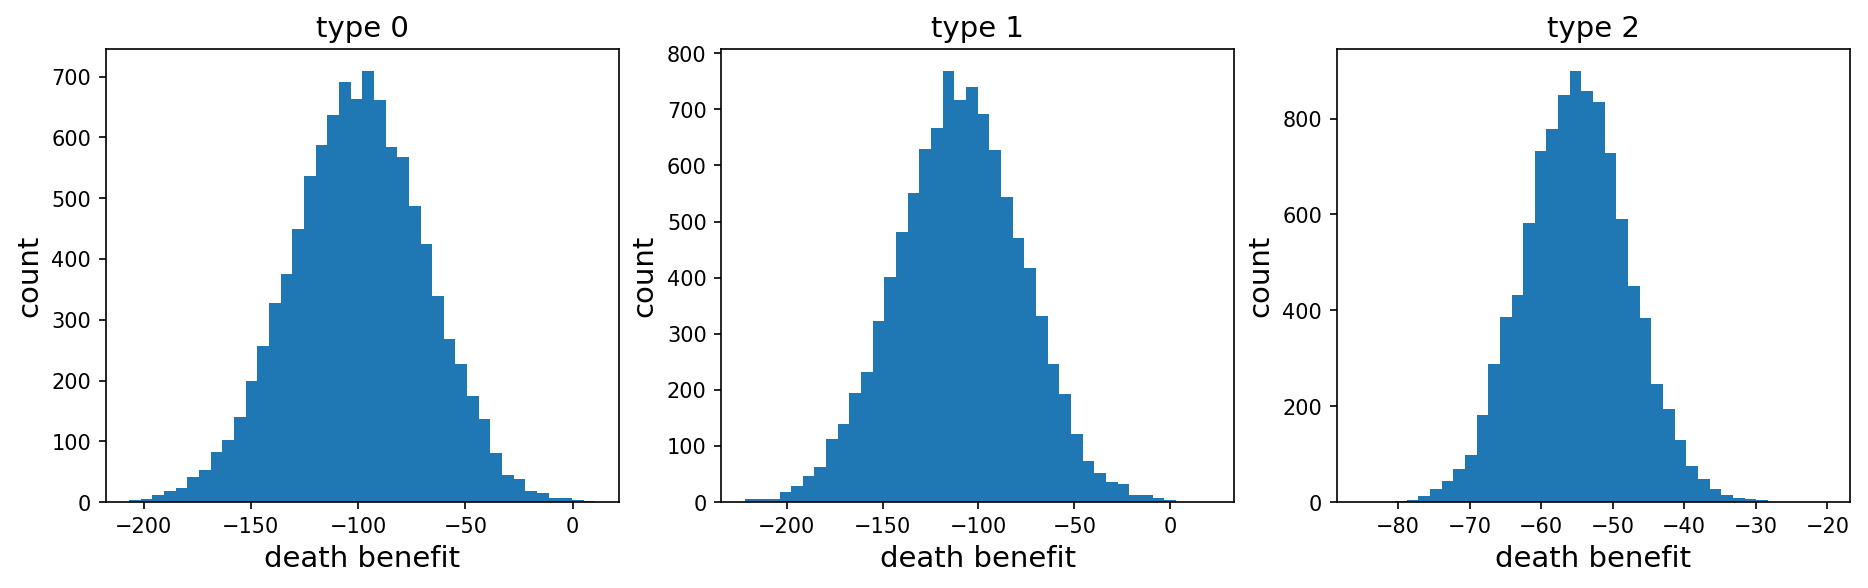

In [9]:
faces = []
faces.append(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 10]))
faces.append(np.array([10, 0, 0, 0, 0, 0, 0, 0, 0, 10]))
faces.append(np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
mortality = (1+np.arange(10))/1000

fig = plt.figure(figsize=(15, 4), dpi=150)

for i in range(3):
    EV_sample = []
    for _ in range(10000):
        EV_sample.append(model(None, faces[i], mortality, n_counts=1000).data)

    EV_sample = np.array(EV_sample)

    ax = fig.add_subplot(1, 3, 1+i)
    ax.set_title('type {}'.format(i), size=14)
    ax.set_xlabel('death benefit', size=14)
    ax.set_ylabel('count', size=14)
    ax.hist(EV_sample, bins=40)
plt.show()

---
## 3. Results

In [10]:
face = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 10])
mortality = (1+np.arange(10))/1000
EV_data = np.array(average_EV(face, mortality)-100)
print('average EV = {}'.format(average_EV(face, mortality)))

mcmc_run_0 = calc_posterior(EV_data, face, mortality, num_samples=num_samples, warmup_steps=warmup_steps)

warmup:   0%|          | 16/10500 [00:00, 156.57it/s, step size=1.04e-04, acc. prob=0.750]

average EV = -100.0


sample: 100%|██████████| 10500/10500 [27:23,  6.39it/s, step size=2.24e-02, acc. prob=0.926]


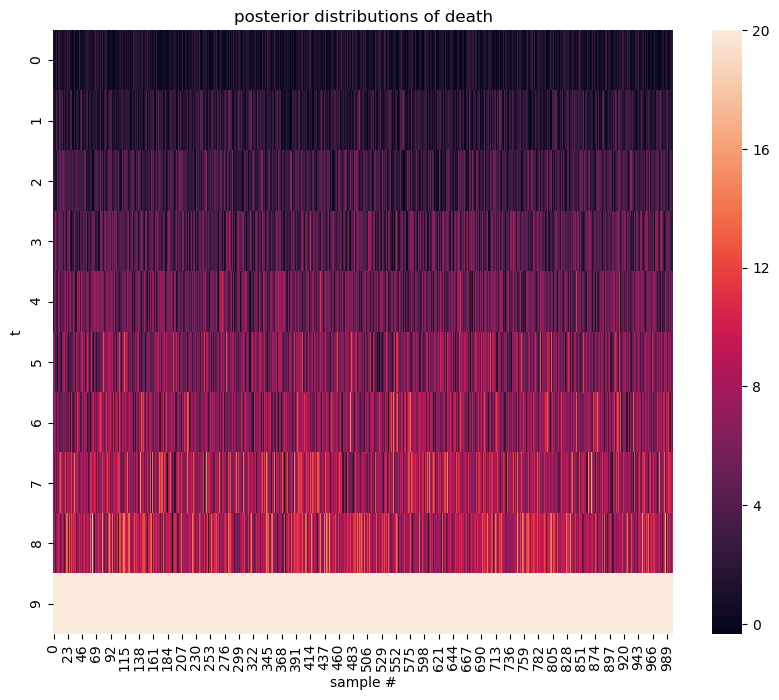

In [11]:
fig = plt.figure(figsize=(10, 8), dpi=100)
sns.heatmap(mcmc_run_0.get_samples()['ds'].T[:, -num_samples::10], robust=True)
plt.title('posterior distributions of death')
plt.xlabel('sample #')
plt.ylabel('t')
plt.show()

Warmup:   0%|          | 0/10500 [00:00, ?it/s]

average EV = -110.0


sample: 100%|██████████| 10500/10500 [2:35:21,  1.13it/s, step size=1.63e-04, acc. prob=0.941]


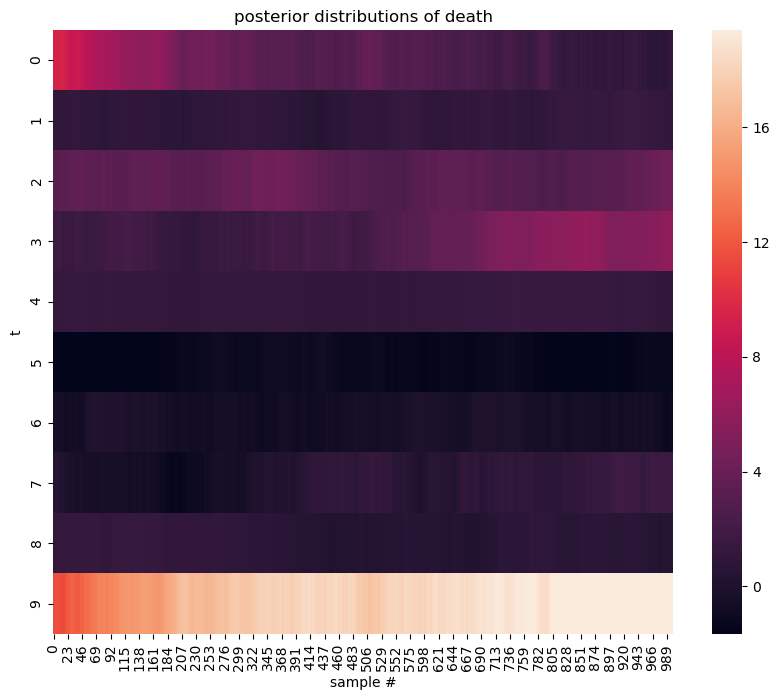

In [12]:
face = np.array([10, 0, 0, 0, 0, 0, 0, 0, 0, 10])
mortality = (1+np.arange(10))/1000
EV_data = np.array(average_EV(face, mortality)-100)
print('average EV = {}'.format(average_EV(face, mortality)))

mcmc_run_1 = calc_posterior(EV_data, face, mortality, num_samples=num_samples, warmup_steps=warmup_steps)

fig = plt.figure(figsize=(10, 8), dpi=100)
sns.heatmap(mcmc_run_1.get_samples()['ds'].T[:, -num_samples::10], robust=True)
plt.title('posterior distributions of death')
plt.xlabel('sample #')
plt.ylabel('t')
plt.show()

Warmup:   0%|          | 0/10500 [00:00, ?it/s]

average EV = -55.0


sample: 100%|██████████| 10500/10500 [2:34:47,  1.13it/s, step size=4.20e-04, acc. prob=0.943]


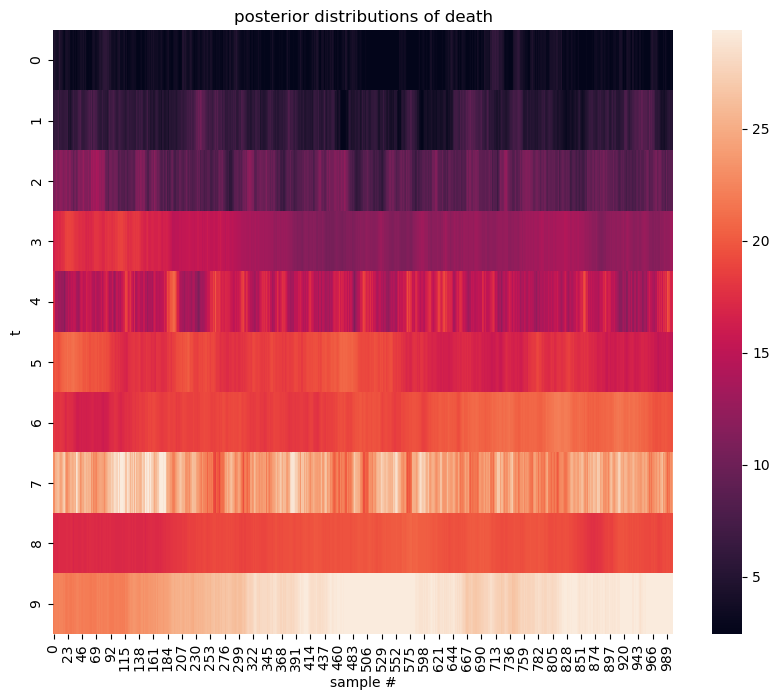

In [13]:
face = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
mortality = (1+np.arange(10))/1000
EV_data = np.array(average_EV(face, mortality)-100)
print('average EV = {}'.format(average_EV(face, mortality)))

mcmc_run_2 = calc_posterior(EV_data, face, mortality, num_samples=num_samples, warmup_steps=warmup_steps)

fig = plt.figure(figsize=(10, 8), dpi=100)
sns.heatmap(mcmc_run_2.get_samples()['ds'].T[:, -num_samples::10], robust=True)
plt.title('posterior distributions of death')
plt.xlabel('sample #')
plt.ylabel('t')
plt.show()

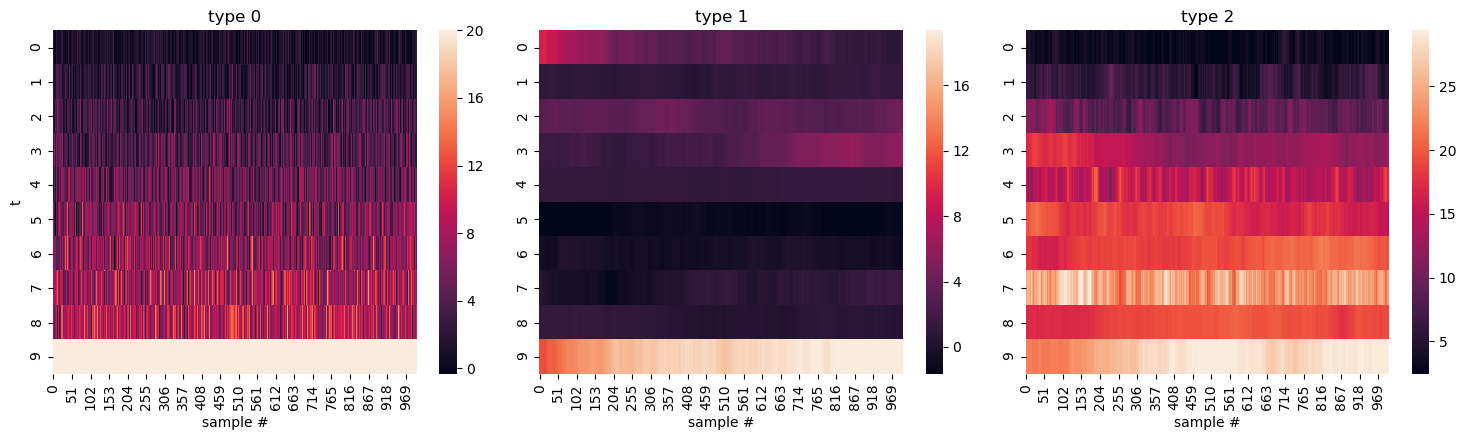

In [14]:
fig = plt.figure(figsize=(15, 4.5), dpi=100)
ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)

sns.heatmap(mcmc_run_0.get_samples()['ds'].T[:, -num_samples::10], robust=True, ax=ax0)
sns.heatmap(mcmc_run_1.get_samples()['ds'].T[:, -num_samples::10], robust=True, ax=ax1)
sns.heatmap(mcmc_run_2.get_samples()['ds'].T[:, -num_samples::10], robust=True, ax=ax2)

ax0.set_title('type 0')
ax1.set_title('type 1')
ax2.set_title('type 2')

ax0.set_xlabel('sample #')
ax1.set_xlabel('sample #')
ax2.set_xlabel('sample #')

ax0.set_ylabel('t')
plt.tight_layout()
plt.show()